## Upper Confidence Bound Action Selection


\begin{equation*}
A_t = \underset{a}{\operatorname{arg max}} \left [ Q_t(a) + c \sqrt \frac {\ln t}{ N_t(a)} \right ]
\end{equation*}


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import __version__ as matplotlib_version

In [2]:
print("numpy version - ", np.__version__)
print("matplotlib version - ", matplotlib_version)

numpy version -  1.17.4
matplotlib version -  3.2.1


In [3]:
# Produce a testbed of 2000 bandit problems
np.random.seed(10)
n_bandit = 2000
n_lever = 10
steps = 1000

testbed = np.random.normal(0,1,(n_bandit,n_lever))
initial_reward_estimates =  np.random.normal(testbed,1)

In [4]:
import multiprocessing

In [5]:
def ucb_c(steps, n_bandit, n_lever,initial_value,confidence,
          testbed, initial_reward_estimates,
          global_reward_list):
    
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    reward_estimates = np.ones((n_bandit,n_lever)) * initial_value  # _per_pull_per_bandit
    
    avg_rewards_per_step = []
    avg_rewards_per_step.append(0)
    avg_rewards_per_step.append(np.mean(initial_reward_estimates)) # step 1

    for step in range(2,steps):
        reward_sum_over_all_bandits_per_step = 0
        for problem_index in range(n_bandit):  
            ucb = reward_estimates[problem_index] + confidence * np.sqrt(np.log(step) / action_count[problem_index])
            chosen_action = np.argmax(ucb)
            
            # Incremental Algorithm
            Rn = np.random.normal(testbed[problem_index][chosen_action],1)
            n = action_count[problem_index] [chosen_action]
            Qn = reward_estimates[problem_index][chosen_action]
            
            Qnew = ( Rn + (n - 1) * Qn ) / n
            
            reward_estimates[problem_index][chosen_action] = Qnew
            action_count[problem_index] [chosen_action] = n+1
            
            reward_sum_over_all_bandits_per_step += Qnew
            

        avg_rewards_per_step.append((reward_sum_over_all_bandits_per_step)/n_bandit)
        
    global_reward_list.append(avg_rewards_per_step)
    return

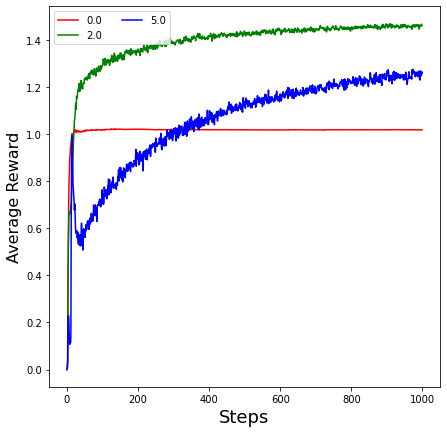

CPU times: user 120 ms, sys: 16.7 ms, total: 136 ms
Wall time: 22.4 s


In [6]:
%%time
with multiprocessing.Manager() as manager:
    global_reward_list = []
    mp_objects = []
    initial_values  = [ 0,   0,    0 ]
    confidence_list = [0.0, 2.0, 5.0]
    color_list      = ['r', 'g', 'b']
    
    for index,eps in enumerate(confidence_list):
        global_reward_list.append(manager.list())
        mp_objects.append(multiprocessing.Process(target=ucb_c,
                                                  args=(steps, n_bandit, n_lever, initial_values[index],confidence_list[index],
                                                        testbed, initial_reward_estimates,
                                                        global_reward_list[len(global_reward_list)-1])) )
    for index in range(len(mp_objects)):
        mp_objects[index].start()

    for index in range(len(mp_objects)):
        mp_objects[index].join()
    
    plt.figure(figsize=(7,7))
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('Average Reward', fontsize=16)
    for  index in range(len(mp_objects)):
        plt.plot(np.arange(steps),global_reward_list[index][0],label=confidence_list[index], color=color_list[index])
    
    plt.legend(loc=2, ncol=2)
    
    plt.show()

### Comparison Between UCB with c=2 and epsilon-greedy with epsilon = 0.1

#### Copy Paste our epsilon-greedy methods 

In [7]:

def rewards_per_step_mp(steps, n_bandit, n_lever,initial_value,
                        testbed, initial_reward_estimates, epsilon,global_reward_list):
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    reward_estimates = np.ones((n_bandit,n_lever)) * initial_value  # _per_pull_per_bandit
    
    print("Initial reward Value : ", str(reward_estimates[0][0]),", epsilon : ", str(epsilon)) # all will be identical
    avg_rewards_per_step = []
    avg_rewards_per_step.append(0)
    avg_rewards_per_step.append(np.mean(initial_reward_estimates)) # step 1

    for step in range(2,steps):
        reward_sum_over_all_bandits_per_step = 0
        for problem_index in range(n_bandit):  
            if np.random.random() > epsilon:
                maxval = np.amax(reward_estimates[problem_index])
                maxval_indices = np.ravel(np.array(np.where(reward_estimates[problem_index] == maxval)))
                random_choice = np.random.choice( maxval_indices ) # Breaking ties randomly
            else :
                 random_choice = np.random.randint(n_lever)

            # Incremental Algorithm
            Rn = np.random.normal(testbed[problem_index][random_choice],1)
            n = action_count[problem_index] [random_choice]
            Qn = reward_estimates[problem_index][random_choice]
            
            Qnew = ( Rn + (n - 1) * Qn ) / n
            
            reward_estimates[problem_index][random_choice] = Qnew
            action_count[problem_index] [random_choice] = n+1
            
            reward_sum_over_all_bandits_per_step += Qnew
            

        avg_rewards_per_step.append((reward_sum_over_all_bandits_per_step)/n_bandit)
        
    global_reward_list.append(avg_rewards_per_step)
    return

In [ ]:
epsilon_greedy_result = []
rewards_per_step_mp (steps, n_bandit, n_lever, 0 , testbed, initial_reward_estimates, 0.1, epsilon_greedy_result)

ucb_result = []
ucb_c(steps, n_bandit, n_lever, 0 , 2,  testbed, initial_reward_estimates, ucb_result)


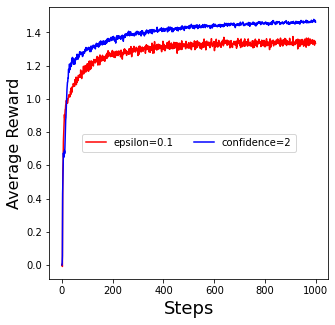

In [12]:
plt.figure(figsize=(5,5))
plt.xlabel('Steps', fontsize=18)
plt.ylabel('Average Reward', fontsize=16)
plt.plot(np.arange(steps), epsilon_greedy_result[0],label=("epsilon=0.1"),color='r')
plt.plot(np.arange(steps), ucb_result[0], label=("confidence=2"), color='b')
plt.legend(loc='center', ncol=2)
plt.show()